# Submission summariser

The submission summariser extracts, parses, and summarises text from PDF submissions using Python and generative AI. This ongoing project involves processing PDF submissions, extracting text, cleaning the data, and using AI-powered models like GPT-3 or GPT-4 to provide summaries and insights from the submissions. The generated summaries are then stored in an SQLite database and can be visualized through WordCloud, bar charts, or exported to Excel sheets for further analysis.

**Note**: Explanations in this doc are still in rough draft and will be polished/clarified in subsequent drafts.

## Preliminary steps
### Installing relevant package
Install necessary packages by running the following command in your Jupyter Notebook:

In [ ]:
!pip install pdfplumber openai pandas tiktoken dotenv

### Downloading and preparing submissions

Manually download submissions and save them in one folder on your machine. 

**Recommended step**: Preprocess larger PDFs (by word count/page count or by size of file) to remove attachments/material that are not necessary for understanding the submission - this can help control cost and, more importantly, help to fit the submission within generative AI context windows (i.e. AI word limits).

## Step one: text extraction
In the first step, the code imports necessary modules and functions, connects to the `submission_data.db` SQLite database, and creates a table called `submissions`. It then processes PDF files, extracts text, counts pages, words, and tokens, and stores the data in the `submissions` table. The table will contain columns for file_name, page_count, word_count, text, tokens, and manual_summarisation.

A helper function `remove_illegal_chars()` removes any illegal characters in the extracted text.

In [ ]:
import os
import pdfplumber
import openai
import json
import pandas as pd
import re
import tiktoken
import sqlite3

# Directory with PDF files
pdf_dir = "/users/arseny/Desktop/testsubmissions" #This is the default that works on Arseny's computer - on other computers, you will be prompted to provide a directory.
while not os.path.exists(pdf_dir):
    pdf_dir = input("Enter the directory where submissions are saved or 'quit' to exit: ")
    
    if pdf_dir.lower() == 'quit':
        print("You chose to exit. Program will terminate.")
        quit()
        
    elif not os.path.exists(pdf_dir):
        print(f"Directory does not exist: {pdf_dir}")

# Token counter
encoding = tiktoken.encoding_for_model('gpt-4') # Replace with other model if not using GPT-4

# SQLite connection
conn = sqlite3.connect('submission_data.db')
c = conn.cursor()

# Create table if it doesn't exist
c.execute('''
    CREATE TABLE IF NOT EXISTS submissions
    (file_name TEXT PRIMARY KEY, page_count INTEGER, word_count INTEGER, text TEXT, tokens INTEGER, manual_summarisation INTEGER DEFAULT 0)
''')

# Function to remove illegal characters
def remove_illegal_chars(text):
    ILLEGAL_CHARACTERS_RE = re.compile(r'[\000-\010]|[\013-\014]|[\016-\037]')
    text = ILLEGAL_CHARACTERS_RE.sub(r'', text)
    return text

    # Loop over the PDF files in the directory
for file_name in os.listdir(pdf_dir):
    if file_name.endswith('.pdf'):
        file_path = os.path.join(pdf_dir, file_name)
        
        # Check if file exists in database
        c.execute("SELECT file_name FROM submissions WHERE file_name = ?", (file_name,))
        if c.fetchone() is None:
            
            # Open the PDF file
            with pdfplumber.open(file_path) as pdf_file:
                
                # Initialize an empty string for the text
                text = ''

                # Loop over the pages and add the text to the string
                for i,  page in enumerate(pdf_file.pages):
                    try:
                        page_text = page.extract_text()
                        page_text = remove_illegal_chars(page_text)
                        text += page_text
                    
                    except Exception as e:
                        print(f"For {file_name},failed to extract text from page {i} with error: {str(e)}")
            
                # Count the pages
                page_count = len(pdf_file.pages)
            
                # Count the words
                word_count = len(text.split())
            
                # Number of tokens
                num_tokens = len(encoding.encode(text))
  
                # Insert into database
                c.execute("INSERT INTO submissions VALUES (?, ?, ?, ?, ?, 0)",
                          (file_name, page_count, word_count, text, num_tokens))
            
# Commit the changes and close the connection to the database
conn.commit()
conn.close()

## Step two: 'cleaning' the data
There might be some issues with the text extraction process, such as getting nonsensical or header/footer text from the PDFs or failing to extract text at all. It is planned to filter for such cases either by manual inspection of the extracted text or by creating a partially automated approach to filter based on the number of words extracted, and by using an LLM (laguage model) to categorize the contents as either actual text or nonsense/header-footer text.

This step will help in filtering out the submissions that need manual summarisation.

## Step three: summarisation
In the third step, the code calls the OpenAI API to summarize the text. The summarization requires having an OpenAI API key saved in an environment file. The summarization process takes into account the extracted text from the submissions and selects an appropriate GPT model based on the number of tokens. 

Using the OpenAI LLM, the code summarizes the text, extracts key policy ideas and concerns, categorizes the author as 'individual', 'government', 'business', 'other', or 'unsure', and rates the sentiment of the text towards Government's current policies. Finally, it stores the summarized results in a new table named `summaries`. 

In [ ]:
# API key

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv("constants.env")) # read local .env file

openai.api_key  = os.environ['OPENAI_API_KEY']

# Create summariser function

def get_completion(prompt, model): 
    messages = [{"role": "user", "content": prompt}]
    response = openai.ChatCompletion.create(
        model=model,
        messages=messages,
        temperature=0, 
    )
    return response.choices[0].message["content"]

# Connect to the SQLite database
conn = sqlite3.connect('submission_data.db')
c = conn.cursor()

# Load the data from the database
c.execute("SELECT * FROM submissions")
rows = c.fetchall()

# Create a new table for the summaries if it doesn't exist
c.execute('''
    CREATE TABLE IF NOT EXISTS summaries
    (file_name TEXT PRIMARY KEY, summary TEXT, ideas TEXT, concerns TEXT, 
     category TEXT, sentiment TEXT, page_count INTEGER, text TEXT, 
     manual_summarisation INTEGER DEFAULT 0, model_used TEXT, LLM_response TEXT)
''')

# Loop over the rows in the fetched data
for row in rows:
    file_name, page_count, word_count, text, tokens, manual_summarisation = row

    # Check if summary already exists in the database
    c.execute("SELECT file_name FROM summaries WHERE file_name = ?", (file_name,))
    if c.fetchone() is not None:
        continue  # Skip this row if it's already in the database
        
    # Check for manual summarisation requirement
    if manual_summarisation == 1:
        model_used = "Manual summarisation required"
        summary = ideas = concerns = category = sentiment = text = model = response = "Manual summarisation required"
        c.execute("INSERT INTO summaries VALUES (?, ?, ?, ?, ?, ?, ?, ?, 1, ?, ?)",
            (file_name, summary, ideas, concerns, category, sentiment, page_count, text, model, response))
    
    else:

        # Determine the model to use based on the number of tokens
        model = "gpt-3.5-turbo-16k-0613" if tokens > 7100 else "gpt-4-0613"
    
        # Summarize the text
        prompt = f"""
        Your task is to perform the following actions as if you are a highly experienced, knowledgeable Australian Government policy adviser who is known for their clear thinking and writing:
        1. Summarise the following public submission extracted below.
        2. Extract the key policy ideas, if any, raised in the submission.
        3. Extract the key concerns, if any, raised in the submission.
        4. Categorise the author as 'individual' (including more than one individual), 'government', 'business', 'other' or 'unsure'. No commentary, just the category. 
        5. On a scale of 1 to 10, rank the sentiment of the text towards the Government's current policy settings or government's proposals (as opposed to proposals suggested by the author or someone else) (1 being very negative and 10 being very positive). No need for commentary, just the number.
        6. Output valid JSON that contains the following keys corresponding to the above tasks: summary, ideas, concerns, category, sentiment.
        Only produce output for step 6 - the JSON output should incorporate the previous answers.

               
        Here is the submission text: [{text}]"""

        try:
            response = get_completion(prompt, model)
        except Exception as e:
            error_message = str(e)
            print(f"Error for file {file_name}: {error_message}")
            c.execute("INSERT INTO summaries VALUES (?, ?, ?, ?, ?, ?, ?, ?, 0, ?, ?)",
                  (file_name, 'Error: Could not generate OpenAI response', 'Error: Could not generate OpenAI response', 'Error: Could not generate OpenAI response', 'Error: Could not generate OpenAI response', 'Error: Could not generate OpenAI response', page_count, text, model, error_message))
            continue

        # Parse the response as JSON
        try:
            response_json = json.loads(response)
            # Extract the fields
            summary = response_json.get('summary', 'Error: could not parse response')
            ideas = json.dumps(response_json.get('ideas', 'Error: could not parse response'))
            concerns = json.dumps(response_json.get('concerns', 'Error: could not parse response'))
            category = response_json.get('category', 'Error: could not parse response')
            sentiment = response_json.get('sentiment', 'Error: could not parse response')
        except json.JSONDecodeError:
            
            # If parsing fails, ask LLM to convert to JSON
            try:
                prompt = f"""
                Your task is to flawlessly convert the following input to valid JSON that contains the following keys: summary, ideas, concerns, category, sentiment.
                Here is the input you must convert to valid JSON: {response}"""
            except Exception as e:
                error_message = str(e)
                print(f"Error for file {file_name}: {error_message}")
                c.execute("INSERT INTO summaries VALUES (?, ?, ?, ?, ?, ?, ?, ?, 0, ?, ?)",
                    (file_name, 'Error: Could not generate OpenAI response', 'Error: Could not generate OpenAI response', 'Error: Could not generate OpenAI response', 'Error: Could not generate OpenAI response', 'Error: Could not generate OpenAI response', page_count, text, model, error_message))
                continue

            try:
                response = get_completion(prompt, model)
                
                # Extract the fields
                summary = response_json.get('summary', 'Error: could not parse response')
                ideas = json.dumps(response_json.get('ideas', 'Error: could not parse response'))
                concerns = json.dumps(response_json.get('concerns', 'Error: could not parse response'))
                category = response_json.get('category', 'Error: could not parse response')
                sentiment = response_json.get('sentiment', 'Error: could not parse response')
            except json.JSONDecodeError:
                 summary = ideas = concerns = category = sentiment = 'Error: could not parse response'
                       
        # Insert into database
        c.execute("INSERT INTO summaries VALUES (?, ?, ?, ?, ?, ?, ?, ?, 0, ?, ?)",
            (file_name, summary, ideas, concerns, category, sentiment, page_count, text, model, response))
    
        print(f'Summarised and stored summary for: {file_name}')

# Commit the changes and close the connection to the database
conn.commit()
conn.close()

## Step four: formatting output
The fourth step involves cleaning the output data further, such as converting lists of ideas and concerns to bullet point lists. It then writes the resulting data to an Excel file, `summaries_and_submissions.xlsx`, for easy examination of the summaries generated.

In [ ]:
import pandas as pd
import sqlite3
import ast

# Connect to the SQLite database
conn = sqlite3.connect('submission_data.db')

# Write the query
query = """
SELECT 
    s.file_name, 
    s.summary, 
    s.ideas, 
    s.concerns, 
    s.category, 
    s.sentiment, 
    s.page_count, 
    sub.word_count, 
    sub.tokens, 
    s.manual_summarisation, 
    s.model_used, 
    s.LLM_response
FROM summaries as s
INNER JOIN submissions as sub
ON s.file_name = sub.file_name
"""

# Execute the query and store the result in a pandas DataFrame
df = pd.read_sql_query(query, conn)

# Filter out rows that require manual summarisation
df = df[df['manual_summarisation'] == 0]

#Filter out rows that LLM didn't process
df = df[df['category'] != 'Error: Could not generate OpenAI response']


# Code below is a bit messy but seems to work - intention is to convert lists to bullet points
# To-do: come back to this code and make neater

def bullet_list_or_string(data_str):
    try:
        data = ast.literal_eval(data_str)
        if isinstance(data, list):
            if len(data) > 1:  # If data contains more than one item, convert to bullet list
                return "\n".join(f'• {item}' for item in data)
            elif len(data) == 1:  # If data is a single item, return as-is
                return data[0]
            else:  # If data is empty, return an empty string
                return ""
        else:  # If data is not a list, return it as-is
            return data_str
    except (ValueError, SyntaxError):  # If literal_eval fails, return the data as-is
        return data_str

# Convert strings to bullet points or leave as single string
df['ideas'] = df['ideas'].apply(bullet_list_or_string)
df['concerns'] = df['concerns'].apply(bullet_list_or_string)

# Write the DataFrame to an Excel file
df.to_excel('summaries_and_submissions.xlsx', index=False)

# Close the connection to the database
conn.close()

## Step five: visualising the summaries
The final step aims to experiment with different visualizations of data, such as bar charts to show the average sentiment for different stakeholder groups and separate word clouds for extracted text, summaries, ideas, and concerns. This will help in getting insights from the summarized content in a graphical manner.

The current visualization implements a bar chart for the average sentiment per author category and word clouds for Summary, Ideas, and Concerns texts.

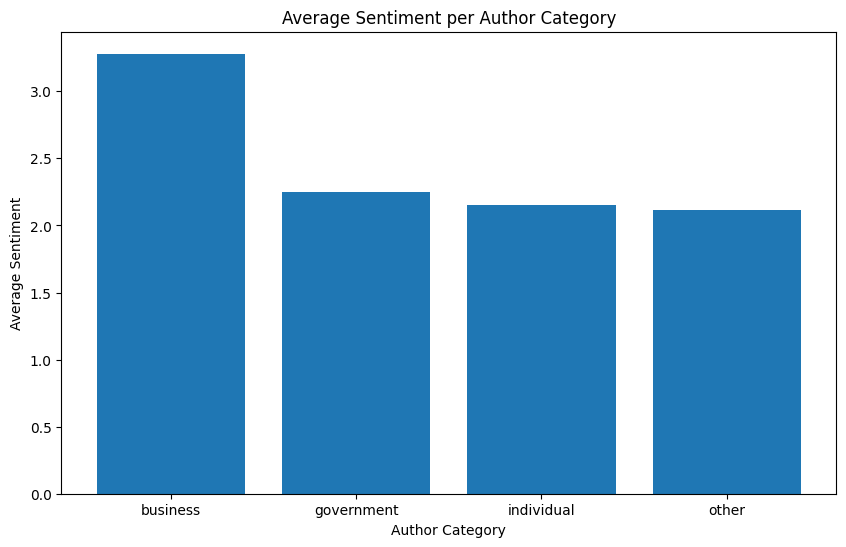

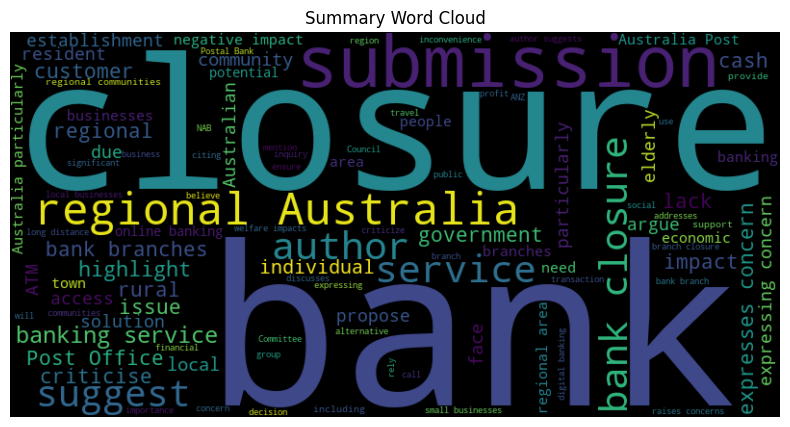

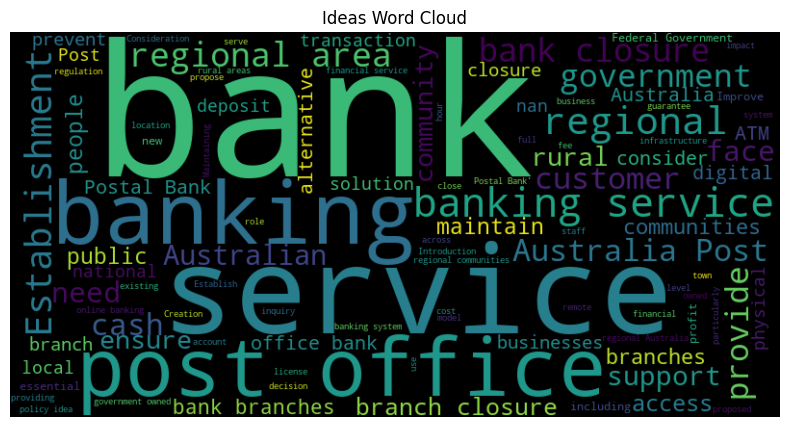

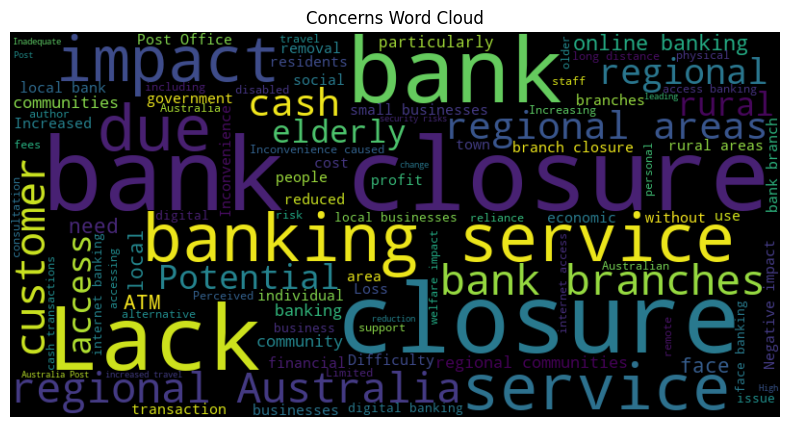

In [17]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pandas as pd

# Excel file path
file_path = f"summaries_and_submissions.xlsx"

# Load the data
df = pd.read_excel(file_path)

# Aggregating average sentiment for each author category
avg_sentiment = df.groupby('category')['sentiment'].mean()

# Creating bar chart
plt.figure(figsize=(10,6))
plt.bar(avg_sentiment.index, avg_sentiment.values)
plt.xlabel('Author Category')
plt.ylabel('Average Sentiment')
plt.title('Average Sentiment per Author Category')
plt.show()

# WordCloud generation function
def generate_wordcloud(text_series, title):
    # Convert all values in the series to strings before joining
    text = ' '.join(text_series.astype(str))
    wordcloud = WordCloud(width=800, height=400, max_words=100).generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Generate word clouds for 'Summary', 'Ideas', and 'Concerns'
generate_wordcloud(df['summary'], 'Summary Word Cloud')
generate_wordcloud(df['ideas'], 'Ideas Word Cloud')
generate_wordcloud(df['concerns'], 'Concerns Word Cloud')


# Experiments

## Trying to build a text splitter for the summariser
*In progress. Experimental code. Purpose is to handle larger submissions. Interim measure till get access to larger AI context windows.*

In [ ]:
        try:
            if #tokenlength < #X (maybe 7000?):
                response = get_completion(prompt)
                print(response)
            else:
                #split into chunks
                # summarise each chunk - perhaps with overlap
                #summarise the combined summaries
            response = get_completion(prompt)
            print(response)
            
            
            
            
# Investigate the solution used here: https://github.com/openai/openai-cookbook/blob/main/examples/How_to_call_functions_for_knowledge_retrieval.ipynb




## Function experiment

*In progress. Experimental code. Experimenting with new ability to call function using OpenAI's API.*

In [ ]:
# API key

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv("constants.env")) # read local .env file

openai.api_key  = os.environ['OPENAI_API_KEY']

# Create summariser function

functions = [
    {
        "name": "submission_summariser",
        "description": "Summarise submissions that you are provided as if you are a highly experienced, knowledgeable Australian Government policy adviser who is known for their clear thinking and writing, outputting in valid JSON format.",
        "parameters": {
            "type": "object",
            "properties": {
                "summary":{
                    "type": "string",
                    "description": "Provide an overall summary of the submission, highlighting key points.",
                },
                "ideas": {
                    "type": "string",
                    "description": "Extract the key policy ideas, if any, raised in the submission.",
                },
                "concerns": {
                    "type": "string",
                    "description": "Extract the key concerns, if any, raised in the submission.", 
                },
                "category": {
                    "type": "string",
                    "description": "Categorise the author as 'individual' (including more than one individual), 'government', 'business', 'other' or 'unsure'. No commentary, just the category.",
                },
                "sentiment": {
                    "type": "integer",
                    "description": "On a scale of 1 to 10, rank the sentiment of the text towards the Government's current policy settings or government's proposals (as opposed to proposals suggested by the author or someone else) (1 being very negative and 10 being very positive)."
                }
            
        }
        }
    }    
]

def get_completion(prompt, model="gpt-4-0613"): 
    messages = [{"role": "user", "content": prompt}]
    response = openai.ChatCompletion.create(
        model=model,
        messages=messages,
        functions = functions,
        temperature=0, 
    )
    return response.choices[0].message["content"]

# Connect to the SQLite database
conn = sqlite3.connect('submission_data_test.db')
c = conn.cursor()

# Load the data from the database
c.execute("SELECT * FROM submissions")
rows = c.fetchall()

# Create a new table for the summaries if it doesn't exist
c.execute('''
    CREATE TABLE IF NOT EXISTS summariestest123
    (file_name TEXT PRIMARY KEY, summary TEXT, ideas TEXT, concerns TEXT, 
     category TEXT, sentiment TEXT, page_count INTEGER, text TEXT, 
     manual_summarisation INTEGER DEFAULT 0, model_used TEXT, LLM_response TEXT)
''')

# Loop over the rows in the fetched data
for row in rows:
    file_name, page_count, word_count, text, tokens, manual_summarisation = row

    # Check if summary already exists in the database
    c.execute("SELECT file_name FROM summaries WHERE file_name = ?", (file_name,))
    if c.fetchone() is not None:
        continue  # Skip this row if it's already in the database
        
    # Check for manual summarisation requirement
    if manual_summarisation == 1:
        model_used = "Manual summarisation required"
        summary = ideas = concerns = category = sentiment = "Manual summarisation required"
    else:

        # Determine the model to use based on the number of tokens
        model = "gpt-3.5-turbo-16k-0613" if tokens > 7100 else "gpt-4-0613"
    
        # Summarize the text
        prompt = f"""
        Your task is to summarise the following text and produce JSON output: [{text}]"""

        try:
            response = get_completion(prompt)
        except Exception as e:
            error_message = str(e)
            print(f"Error for file {file_name}: {error_message}")
            c.execute("INSERT INTO summaries VALUES (?, ?, ?, ?, ?, ?, ?, ?, 0, ?, ?)",
                  (file_name, 'Error: Could not generate OpenAI response', 'Error: Could not generate OpenAI response', 'Error: Could not generate OpenAI response', 'Error: Could not generate OpenAI response', 'Error: Could not generate OpenAI response', page_count, text, model, error_message))
            continue

        # Parse the response as JSON
        try:
            response_json = json.loads(response)
            # Extract the fields
            summary = response_json.get('summary', 'Error: could not parse response')
            ideas = json.dumps(response_json.get('ideas', 'Error: could not parse response'))
            concerns = json.dumps(response_json.get('concerns', 'Error: could not parse response'))
            category = response_json.get('category', 'Error: could not parse response')
            sentiment = response_json.get('sentiment', 'Error: could not parse response')
        except json.JSONDecodeError:
            
            # If parsing fails, ask LLM to convert to JSON
            try:
                prompt = f"""
                Your task is to flawlessly convert the following input to valid JSON that contains the following keys: summary, ideas, concerns, category, sentiment.
                Here is the input you must convert to valid JSON: {response}"""
            except Exception as e:
                error_message = str(e)
                print(f"Error for file {file_name}: {error_message}")
                c.execute("INSERT INTO summaries VALUES (?, ?, ?, ?, ?, ?, ?, ?, 0, ?, ?)",
                    (file_name, 'Error: Could not generate OpenAI response', 'Error: Could not generate OpenAI response', 'Error: Could not generate OpenAI response', 'Error: Could not generate OpenAI response', 'Error: Could not generate OpenAI response', page_count, text, model, error_message))
                continue

            try:
                response = get_completion(prompt)
                
                # Extract the fields
                summary = response_json.get('summary', 'Error: could not parse response')
                ideas = json.dumps(response_json.get('ideas', 'Error: could not parse response'))
                concerns = json.dumps(response_json.get('concerns', 'Error: could not parse response'))
                category = response_json.get('category', 'Error: could not parse response')
                sentiment = response_json.get('sentiment', 'Error: could not parse response')
            except json.JSONDecodeError:
                 summary = ideas = concerns = category = sentiment = 'Error: could not parse response'
                       
        # Insert into database
        c.execute("INSERT INTO summaries VALUES (?, ?, ?, ?, ?, ?, ?, ?, 0, ?, ?)",
            (file_name, summary, ideas, concerns, category, sentiment, page_count, text, model, response))
    
        print(f'Summarised and stored summary for: {file_name}')

# Commit the changes and close the connection to the database
conn.commit()
conn.close()